<h1> Local Interpretable Model-Agnostic Explanations (LIME) on ISIC data </h1>

[Metta et. al] <br />
The two of the major XAI techiniques currently in use are: LIME & SHAP.
They are data agnostic local explainers - so the data format should not matter (we can use image data)

LIME and SHAP can be applied to explain image classifiers and return explanation in the form of saliency maps. 
Unfortunately, both lime and shap require a segmentation procedure that affects the explanation: the neighborhoods considered are no longer plausible instances but simply the image under analysis with some pixels "obscured".
This is also not beneficial nor trustful in a medical context.
To overcome this issue, in abele has been proposed, a local model agnostic explainer specifically designed for image classifiers. 

But are we absolutely sure about LIME? (check the other notebook for SHAP)

Let's check


In [1]:
import os
from argparse import ArgumentParser
from gc import callbacks
from subprocess import call
import PIL
import random
import matplotlib.image as im
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from pytorch_gradcam import gradcam
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.svm import SVC
from torchsummary import summary
from PIL import Image
from matplotlib import cm
from datasets.seven_point_dataset import SevenPointDataset
from datasets.isic_2019 import ISIC2019Dataset

from gradcam import *
from model import SimpleClassifier

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Let's load the data and setup as needed. Let's also load the model and update it with presaved checkpoint parameters

In [2]:
dataset = ISIC2019Dataset('/space/derma-data/isic-2019', batch_size=32, normalize_weights=True, md_choice='all', sampling_rate=-1)

dataset.setup()
early_stopping=False #flag
#optimizer=adam
model = SimpleClassifier(model_name='resnet50',learning_rate=3e-5,
                        class_weights=list(dataset.class_weights),
                        num_classes=dataset.num_classes,
                        check_early_stop=early_stopping,
                        #optimizer=optimizer                            
                        )

#checkpoint = torch.load('saved_model.ckpt') #vgg16, 1e-3, batch 32, 350epoch

checkpoint = torch.load('/u/home/javadov/ai_kit/ai-student-starter-kit/checkpoints/Isicdata_resnet_50.ckpt')
model.load_state_dict(checkpoint['state_dict'])

all: ['anatom_site_general', 'sex', 'age_approx']


/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<All keys matched successfully>

Model looks as following  (ResNet50)

In [3]:
model

SimpleClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


We load the trainer and do the predictions from test dataset. We then disassemble the predictions into features and the actual labels

In [4]:
if early_stopping:
    callbacks=[EarlyStopping(min_delta=0.001,monitor="val_loss", patience=10,strict=False, verbose=True,mode="min")]
else:
    callbacks=None
print(model)
trainer = pl.Trainer(devices=1,
                     accelerator='gpu',
                     logger=False,
                     callbacks=False,
                     checkpoint_callback=False,
                    )

predictions = trainer.predict(model, dataset.test_dataloader())


features, labels = zip(*predictions)

/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/u/home/javadov/miniconda3/envs/dermaproj1/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SimpleClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: 0it [00:00, ?it/s]

Just to test, labels look like following. As expected there are 7 classes in total (0..6)

In [5]:
labels

(tensor([0, 1, 2, 1, 2, 5, 5, 0, 0, 5, 3, 4, 0, 6, 0, 2, 2, 0, 0, 0, 6, 2, 0, 1,
         4, 5, 6, 0, 3, 0, 0, 4]),
 tensor([0, 1, 1, 5, 5, 2, 2, 0, 0, 1, 2, 0, 0, 6, 0, 0, 0, 5, 1, 2, 3, 6, 1, 2,
         0, 2, 0, 1, 0, 5, 0, 5]),
 tensor([4, 0, 0, 2, 1, 1, 7, 0, 1, 2, 2, 2, 0, 4, 0, 5, 0, 0, 1, 0, 0, 1, 0, 0,
         0, 1, 3, 2, 0, 0, 5, 0]),
 tensor([0, 2, 0, 0, 2, 2, 0, 0, 5, 0, 0, 2, 1, 0, 5, 0, 2, 0, 5, 0, 0, 2, 2, 2,
         0, 2, 1, 0, 0, 1, 2, 1]),
 tensor([2, 5, 1, 0, 2, 5, 2, 1, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         5, 0, 1, 0, 5, 0, 3, 0]),
 tensor([2, 2, 0, 4, 0, 0, 5, 0, 2, 0, 1, 0, 2, 0, 4, 0, 2, 0, 1, 0, 0, 2, 0, 0,
         2, 0, 0, 4, 0, 2, 0, 2]),
 tensor([0, 5, 0, 5, 0, 0, 3, 2, 2, 1, 0, 0, 5, 6, 5, 2, 0, 3, 1, 0, 2, 1, 0, 5,
         1, 1, 0, 2, 1, 0, 0, 0]),
 tensor([2, 5, 0, 0, 0, 5, 0, 0, 0, 2, 0, 5, 5, 0, 2, 1, 3, 6, 0, 0, 0, 2, 5, 1,
         0, 0, 0, 2, 0, 2, 0, 1]),
 tensor([0, 0, 3, 0, 2, 0, 1, 0, 2, 0, 6, 5, 1, 0, 5, 0, 4, 5, 6, 5, 2, 

Let's have a look at the features as well

In [6]:
features = torch.vstack(features)


In [7]:
features


tensor([[  8.5951,  -9.5589,   1.5703,  ...,  -5.5002,  -7.1564,  -7.6950],
        [ -6.7276,   9.1975,  -1.1407,  ...,  -4.0690,  -8.7934,  -8.9423],
        [  6.8815, -14.7966,   5.8562,  ...,  -1.7256,  -8.6379,  -9.0005],
        ...,
        [ 10.1438, -22.0661,  -2.3828,  ...,  -1.4997,  -8.7178,  -5.0368],
        [  2.2988,   3.6050,   1.6475,  ...,  -3.2283,  -5.1047,  -8.2145],
        [  8.4277, -14.6645, -15.4019,  ...,   1.8079,  -8.6836,  -3.2217]])

Gathering all labels in a single array

In [8]:
labels = torch.cat(labels)


In [9]:
labels.shape

torch.Size([4262])

Getting a batch of data and forward passing through the model


In [10]:
(input_original, input, tst, label) = next(iter(dataset.train_dataloader()))
output = model.forward(input)



Visualizing the Meta-data, as it may come handy in the future

In [11]:
tst

tensor([[1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.7500],
        [1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.1500],
        [0.1000, 0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 1.0000,
         0.1000, 0.7000],
        [0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 1.0000,
         0.1000, 0.5500],
        [0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.7000],
        [0.1000, 0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 1.0000,
         0.1000, 0.8000],
        [1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.8000],
        [0.1000, 0.1000, 0.1000, 1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.6500],
        [1.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         1.0000, 0.4500],
        [0.1000, 0.1000, 1.0000, 0.10

In [12]:
# import lime
# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt
# import random
# from PIL import Image
# import torch.nn as nn
# import numpy as np
# import os, json

# import torch
# from torchvision import models, transforms
# from torch.autograd import Variable
# import torch.nn.functional as F

Lime produces the array of images from original input image by pertubation algorithm. 
So we need to provide two things: 
(1) original image as numpy array 
(2) classification function that would take array of perturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms: 
(1) to take PIL image, resize and crop it 
(2) take resized, cropped image and apply whitening.

In [13]:
img = np.transpose(input_original.cpu().detach().numpy()[22,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   
normed_torch_img


tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

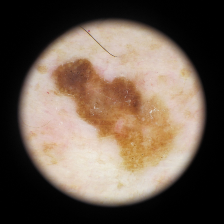

In [14]:
pil_img

In [15]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf  

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

Let's visualize the raw image first

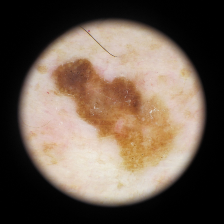

In [16]:
pil_img

Let's find the blackbox model's predicted class

In [17]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

5

In [18]:
label[22]

tensor(5)

In [19]:
from lime import lime_image


In [20]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(pil_img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000) 

  0%|          | 0/5000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.



In [29]:
from skimage.segmentation import mark_boundaries


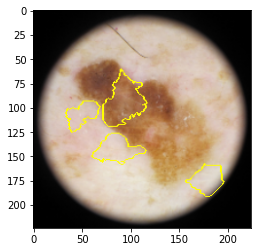

In [21]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.



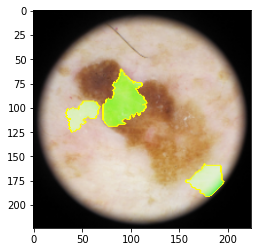

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [27]:
img = np.transpose(input_original.cpu().detach().numpy()[9,:,:,:],(1,2,0))
img1 = img.astype(np.uint8)
pil_img = Image.fromarray(img1).convert('RGB')
torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(pil_img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=5000) 

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)


  0%|          | 0/5000 [00:00<?, ?it/s]

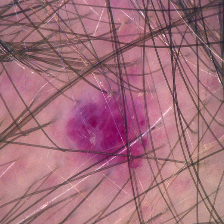

In [28]:
pil_img

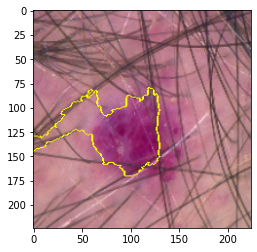

In [29]:
plt.imshow(img_boundry1)


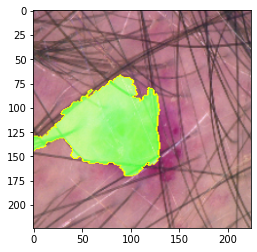

In [30]:
plt.imshow(img_boundry2)

In [31]:
def limexai(order=5,top_labels=5,num_samples=1000, num_features1=5,num_features2=10, hide_rest=False):
    img = np.transpose(input_original.cpu().detach().numpy()[order,:,:,:],(1,2,0))
    img1 = img.astype(np.uint8)
    pil_img = Image.fromarray(img1).convert('RGB')
    torch_img = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])(pil_img)
    normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]   

    pill_transf = get_pil_transform()
    preprocess_transform = get_preprocess_transform()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(pil_img)), 
                                             batch_predict, # classification function
                                             top_labels=top_labels, 
                                             hide_color=0, 
                                             num_samples=num_samples) 

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features1, hide_rest=hide_rest)
    img_boundry1 = mark_boundaries(temp/255.0, mask)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features2, hide_rest=hide_rest)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    return pil_img,img_boundry1,img_boundry2

In [38]:
pil_img, img_boundry1, img_boundry2= limexai(7,num_samples=5000, num_features1=3, num_features2=5)

  0%|          | 0/5000 [00:00<?, ?it/s]

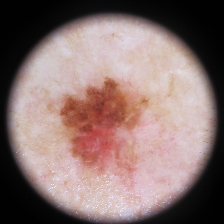

In [39]:
pil_img

In [40]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

2

In [42]:
label[7]

tensor(2)

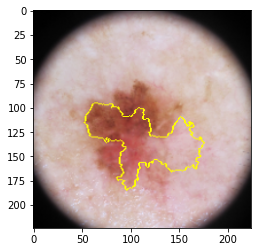

In [43]:
plt.imshow(img_boundry1)

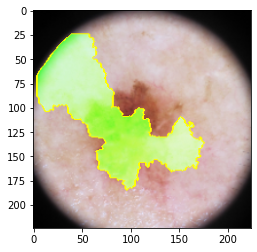

In [44]:
plt.imshow(img_boundry2)

In [55]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred.squeeze().argmax()

0

In [56]:
label[8]

tensor(0)

[Hurtado et. al] <br />
XAI methods provide advantages on model result interpretation in Melanoma image classification. <br />
Concretely, LIME performs better than SHAP gradient explainer in terms of reproducibility and execution time.


Now let's check some of the data points with less number of features:

In [67]:
pil_img, img_boundry1, img_boundry2= limexai(order=29,num_samples=10000,num_features1=3, num_features2=5, hide_rest=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

With 3 features

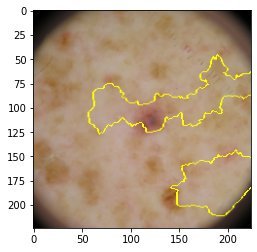

In [68]:
plt.imshow(img_boundry1)

With 5 features

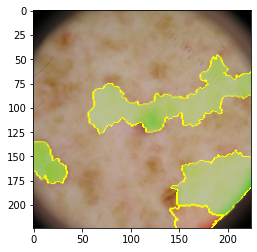

In [69]:
plt.imshow(img_boundry2)

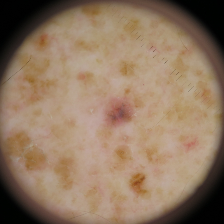

In [70]:
pil_img

In [82]:
pil_img, img_boundry1, img_boundry2= limexai(order=30,num_features1=3, num_features2=5, hide_rest=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

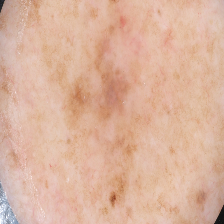

In [83]:
pil_img

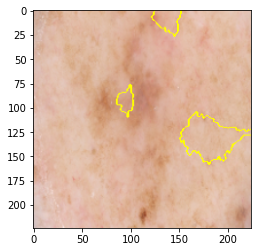

In [84]:
plt.imshow(img_boundry1)

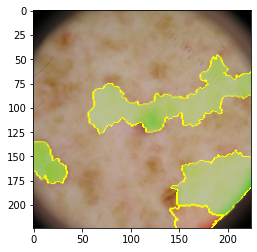

In [71]:
plt.imshow(img_boundry2)

In [ ]:
plt